## using only 2 landmarks in GaussianKernel #2

In [1]:
%matplotlib inline
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

Using TensorFlow backend.


In [2]:
import sys
sys.path.append('/home/admin/github/wordroid.sblo.jp/lib')
from keras_ex.GaussianKernel import GaussianKernel, GaussianKernel2

# or copy and paste the definition of `GaussianKernel` here.

In [3]:
import numpy as np
import pandas as pd
from sklearn import datasets
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn import cluster, datasets, mixture
from sklearn.datasets import load_digits
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import f1_score, classification_report, confusion_matrix

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns

from keras.layers import Input, Embedding, LSTM, GRU, Dense, Dropout, Lambda, \
    Conv1D, Conv2D, Conv3D, \
    Conv2DTranspose, \
    AveragePooling1D, \
    MaxPooling1D, MaxPooling2D, MaxPooling3D, \
    GlobalAveragePooling1D, \
    GlobalMaxPooling1D, GlobalMaxPooling2D, \
    LocallyConnected1D, LocallyConnected2D, \
    concatenate, Flatten, Average, Activation, \
    RepeatVector, Permute, Reshape, Dot, \
    multiply, dot, add, \
    PReLU, \
    Bidirectional, TimeDistributed, \
    SpatialDropout1D, \
    BatchNormalization
from keras.models import Model, Sequential
from keras import losses
from keras.callbacks import BaseLogger, ProgbarLogger, Callback, History
from keras.wrappers.scikit_learn import KerasClassifier
from keras import regularizers
from keras import initializers
from keras.metrics import categorical_accuracy
from keras.constraints import maxnorm, non_neg
from keras.optimizers import RMSprop
from keras.utils import to_categorical
from keras import backend as K

In [4]:
digits = load_digits()
X, y = digits.data, digits.target
X[:5]

array([[  0.,   0.,   5.,  13.,   9.,   1.,   0.,   0.,   0.,   0.,  13.,
         15.,  10.,  15.,   5.,   0.,   0.,   3.,  15.,   2.,   0.,  11.,
          8.,   0.,   0.,   4.,  12.,   0.,   0.,   8.,   8.,   0.,   0.,
          5.,   8.,   0.,   0.,   9.,   8.,   0.,   0.,   4.,  11.,   0.,
          1.,  12.,   7.,   0.,   0.,   2.,  14.,   5.,  10.,  12.,   0.,
          0.,   0.,   0.,   6.,  13.,  10.,   0.,   0.,   0.],
       [  0.,   0.,   0.,  12.,  13.,   5.,   0.,   0.,   0.,   0.,   0.,
         11.,  16.,   9.,   0.,   0.,   0.,   0.,   3.,  15.,  16.,   6.,
          0.,   0.,   0.,   7.,  15.,  16.,  16.,   2.,   0.,   0.,   0.,
          0.,   1.,  16.,  16.,   3.,   0.,   0.,   0.,   0.,   1.,  16.,
         16.,   6.,   0.,   0.,   0.,   0.,   1.,  16.,  16.,   6.,   0.,
          0.,   0.,   0.,   0.,  11.,  16.,  10.,   0.,   0.],
       [  0.,   0.,   0.,   4.,  15.,  12.,   0.,   0.,   0.,   0.,   3.,
         16.,  15.,  14.,   0.,   0.,   0.,   0.,   8.,  13.

In [5]:
X = X.reshape((X.shape[0], -1))
X[:5]

array([[  0.,   0.,   5.,  13.,   9.,   1.,   0.,   0.,   0.,   0.,  13.,
         15.,  10.,  15.,   5.,   0.,   0.,   3.,  15.,   2.,   0.,  11.,
          8.,   0.,   0.,   4.,  12.,   0.,   0.,   8.,   8.,   0.,   0.,
          5.,   8.,   0.,   0.,   9.,   8.,   0.,   0.,   4.,  11.,   0.,
          1.,  12.,   7.,   0.,   0.,   2.,  14.,   5.,  10.,  12.,   0.,
          0.,   0.,   0.,   6.,  13.,  10.,   0.,   0.,   0.],
       [  0.,   0.,   0.,  12.,  13.,   5.,   0.,   0.,   0.,   0.,   0.,
         11.,  16.,   9.,   0.,   0.,   0.,   0.,   3.,  15.,  16.,   6.,
          0.,   0.,   0.,   7.,  15.,  16.,  16.,   2.,   0.,   0.,   0.,
          0.,   1.,  16.,  16.,   3.,   0.,   0.,   0.,   0.,   1.,  16.,
         16.,   6.,   0.,   0.,   0.,   0.,   1.,  16.,  16.,   6.,   0.,
          0.,   0.,   0.,   0.,  11.,  16.,  10.,   0.,   0.],
       [  0.,   0.,   0.,   4.,  15.,  12.,   0.,   0.,   0.,   0.,   3.,
         16.,  15.,  14.,   0.,   0.,   0.,   0.,   8.,  13.

In [6]:
X_sc = X / 16.0
X_sc.shape

(1797, 64)

In [7]:
X_sc

array([[ 0.    ,  0.    ,  0.3125, ...,  0.    ,  0.    ,  0.    ],
       [ 0.    ,  0.    ,  0.    , ...,  0.625 ,  0.    ,  0.    ],
       [ 0.    ,  0.    ,  0.    , ...,  1.    ,  0.5625,  0.    ],
       ..., 
       [ 0.    ,  0.    ,  0.0625, ...,  0.375 ,  0.    ,  0.    ],
       [ 0.    ,  0.    ,  0.125 , ...,  0.75  ,  0.    ,  0.    ],
       [ 0.    ,  0.    ,  0.625 , ...,  0.75  ,  0.0625,  0.    ]])

In [8]:
y

array([0, 1, 2, ..., 8, 9, 8])

In [9]:
y_cat = to_categorical(y)
y_cat

array([[ 1.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  1.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  1., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  1.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  1.],
       [ 0.,  0.,  0., ...,  0.,  1.,  0.]])

### create model

In [10]:
'''
chose landmarks from sample
pick 10 data each digit
'''
np.random.seed(0)
num_lm0 = 10
num_lm = num_lm0 * 10
init_list = []
for ii in range(10):
    init_wgt0 = X_sc[y==ii]
    init_wgt0 = init_wgt0[np.random.choice(range(init_wgt0.shape[0]), size=num_lm0, replace=False)] + \
                np.random.normal(scale=0.01, size=num_lm0*64).reshape(num_lm0, 64)
    init_list.append(init_wgt0)
init_wgt = np.vstack(init_list)
init_wgt = init_wgt[np.random.permutation(range(init_wgt.shape[0]))]
init_wgt.shape

(100, 64)

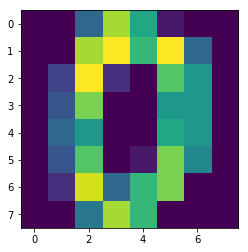

In [11]:
plt.imshow(X[0].reshape((8,8)))

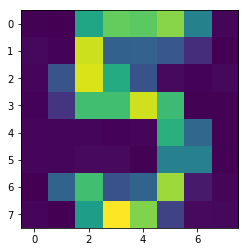

In [12]:
plt.imshow(init_wgt[0].reshape((8,8)))

In [13]:
np.random.seed(0)
num_lm2 = 2

print(1./(2.*num_lm*0.1))
print(1./(2.*64*0.1))

def make_modelz(gamma=0, gamma_svm=0.1, name='DUMMY'):
    inp = Input(shape=(64,), name='inp')
    oup = inp
    
    oup_gk1 = GaussianKernel(num_lm, 64, kernel_gamma=1./(2.*64*0.1), weights=[init_wgt], name='gkernel1')(oup)
    model_gk1 = Model(inp, oup_gk1)
    
    oup = Dense(2)(oup_gk1)
    model_dense = Model(inp, oup)
    oup = Dense(10, activation='softmax')(oup)
    
    model = Model(inp, oup)
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return {
        'model': model,
        'model_gk1': model_gk1,
        'model_dense': model_dense,
    }

models = make_modelz()
model = models['model']
model.summary()

0.05
0.078125
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inp (InputLayer)             (None, 64)                0         
_________________________________________________________________
gkernel1 (GaussianKernel)    (None, 100)               6400      
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 202       
_________________________________________________________________
dense_2 (Dense)              (None, 10)                30        
Total params: 6,632
Trainable params: 6,632
Non-trainable params: 0
_________________________________________________________________


### train

In [14]:
model.fit(X_sc, y_cat, verbose=0,
          batch_size=32,
          epochs=300)

/home/admin/miniconda3/envs/da02/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:95: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


### predict

In [15]:
y_pred = model.predict(X_sc, batch_size=1024)
y_pred

array([[  9.57400143e-01,   5.88468252e-09,   4.11021151e-02, ...,
          2.21574544e-15,   8.88643683e-07,   1.15309466e-12],
       [  2.53364988e-06,   7.96825767e-01,   1.51096995e-03, ...,
          4.62893723e-03,   7.61475712e-02,   1.96644178e-04],
       [  9.47195515e-02,   3.46670523e-02,   5.81551909e-01, ...,
          1.33000651e-06,   4.13815565e-02,   1.52656526e-06],
       ..., 
       [  4.80855924e-05,   7.87727654e-01,   9.82782338e-03, ...,
          1.32511102e-03,   1.15194201e-01,   9.96757590e-05],
       [  2.22642100e-08,   3.64998057e-02,   4.67009173e-04, ...,
          1.14954203e-01,   2.22801134e-01,   6.16000831e-01],
       [  4.41628945e-05,   3.43711346e-01,   3.39699835e-02, ...,
          8.64853989e-03,   5.96512854e-01,   1.20735578e-02]], dtype=float32)

In [16]:
confusion_matrix(y, np.argmax(y_pred, axis=1))

array([[170,   0,   5,   0,   0,   0,   3,   0,   0,   0],
       [  0, 167,   0,   0,   1,   0,   0,   3,  11,   0],
       [  0,   2, 166,   0,   0,   3,   3,   0,   3,   0],
       [  0,   0,   1, 169,   0,   3,   0,   0,   4,   6],
       [  0,   7,   0,   0, 169,   0,   2,   3,   0,   0],
       [  1,   0,   6,  10,   0, 162,   0,   0,   2,   1],
       [  1,   2,   1,   0,   1,   0, 176,   0,   0,   0],
       [  0,   1,   0,   0,   1,   0,   0, 174,   1,   2],
       [  0,  30,   3,   3,   0,   0,   0,   0, 127,  11],
       [  0,   1,   0,   7,   0,   0,   0,  12,   5, 155]])

In [17]:
print(classification_report(y, np.argmax(y_pred, axis=1)))

             precision    recall  f1-score   support

          0       0.99      0.96      0.97       178
          1       0.80      0.92      0.85       182
          2       0.91      0.94      0.92       177
          3       0.89      0.92      0.91       183
          4       0.98      0.93      0.96       181
          5       0.96      0.89      0.93       182
          6       0.96      0.97      0.96       181
          7       0.91      0.97      0.94       179
          8       0.83      0.73      0.78       174
          9       0.89      0.86      0.87       180

avg / total       0.91      0.91      0.91      1797



### plot output of GaussianKernel layer

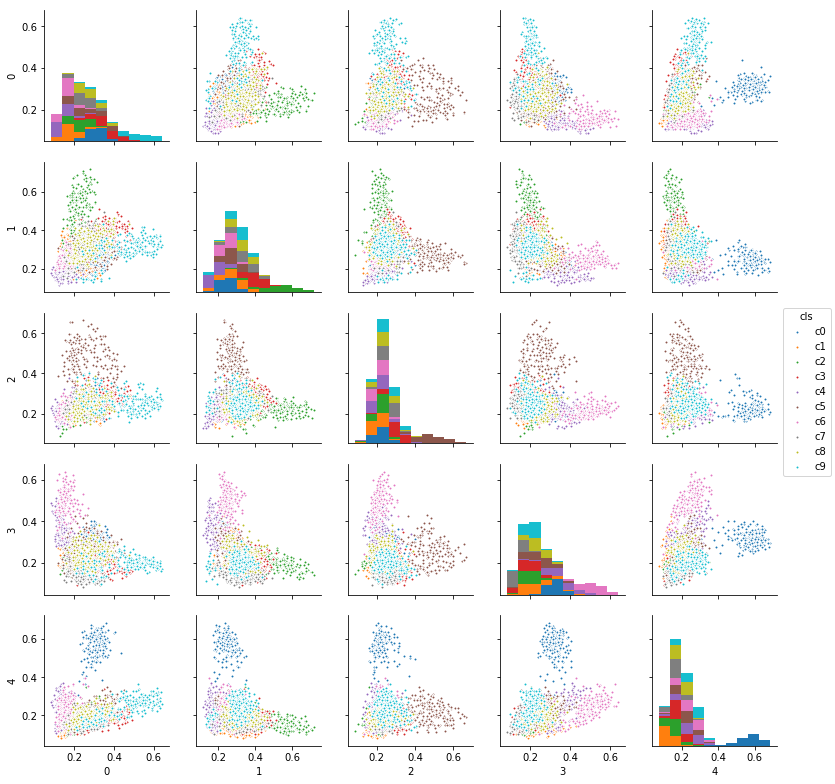

In [18]:
gk1_pred = models['model_gk1'].predict(X_sc, batch_size=1024)
df = pd.DataFrame(gk1_pred[:,:5])
df['cls'] = ['c'+str(ee) for ee in y]
sns.pairplot(df, markers='.', hue='cls', size=2.2)

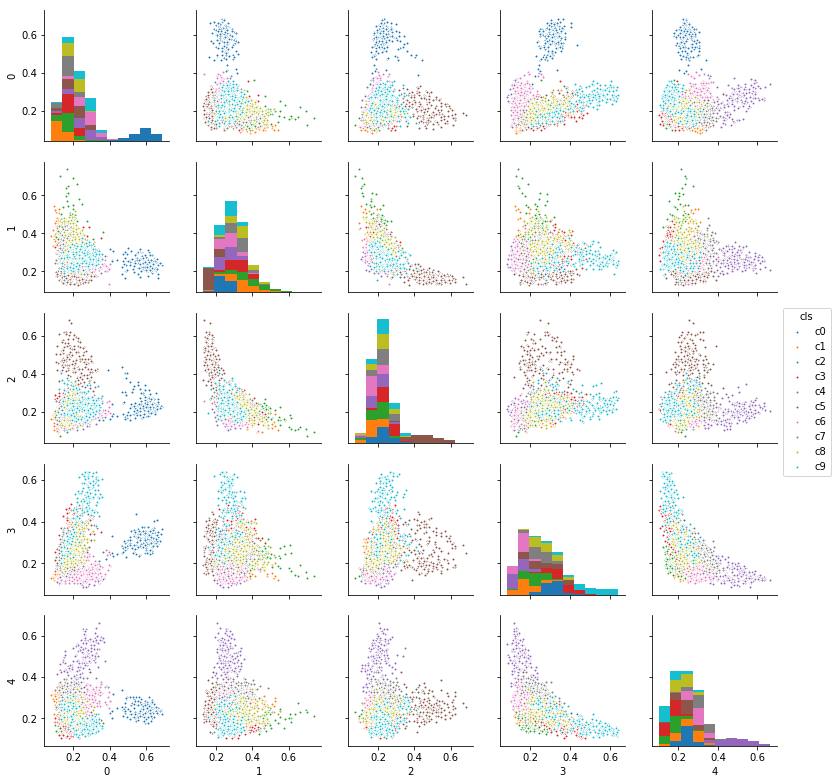

In [19]:
df = pd.DataFrame(gk1_pred[:,50:55])
df['cls'] = ['c'+str(ee) for ee in y]
sns.pairplot(df, markers='.', hue='cls', size=2.2)

### plot output of Dense layer

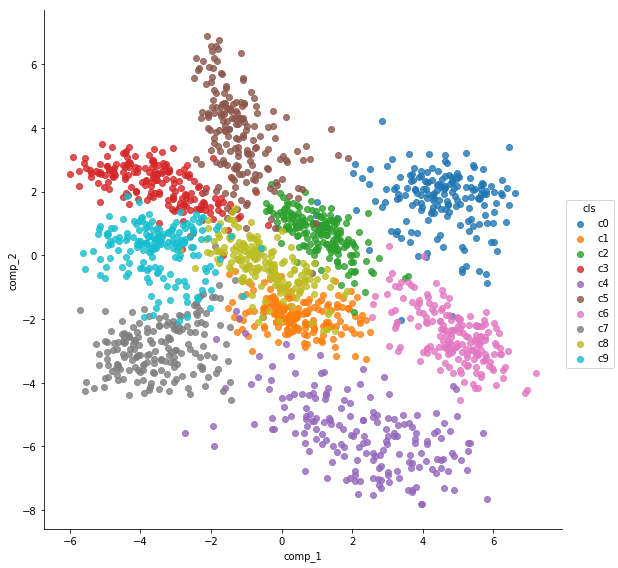

In [20]:
pred_dense = models['model_dense'].predict(X_sc)
df = pd.DataFrame(pred_dense[:,:5])
df.columns = ["comp_1", "comp_2"]
df['cls'] = ['c'+str(ee) for ee in y]
sns.lmplot("comp_1", "comp_2", hue = "cls", data=df, fit_reg=False, size=8)